karate

In [1]:
#!pip install spektral

In [2]:
import numpy as np
import networkx as nx
import tensorflow as tf
from spektral.data import Dataset, Graph
from spektral.layers import GCNConv
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

2025-02-28 19:39:29.472965: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-28 19:39:29.473372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-28 19:39:29.747146: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 19:39:30.205896: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-28 19:39:32.350844: W tensorflow/compiler/tf2

In [3]:
import spektral.layers
print(dir(spektral.layers))


['AGNNConv', 'APPNPConv', 'ARMAConv', 'AsymCheegerCutPool', 'CensNetConv', 'ChebConv', 'CrystalConv', 'DMoNPool', 'DiffPool', 'DiffusionConv', 'Disjoint2Batch', 'ECCConv', 'EdgeConv', 'GATConv', 'GCNConv', 'GCSConv', 'GINConv', 'GINConvBatch', 'GTVConv', 'GatedGraphConv', 'GeneralConv', 'GlobalAttentionPool', 'GlobalAttnSumPool', 'GlobalAvgPool', 'GlobalMaxPool', 'GlobalSumPool', 'GraphMasking', 'GraphSageConv', 'InnerProduct', 'JustBalancePool', 'K', 'LaPool', 'Layer', 'MessagePassing', 'MinCutPool', 'MinkowskiProduct', 'SAGPool', 'SRCPool', 'SortPool', 'SparseDropout', 'TAGConv', 'TopKPool', 'XENetConv', 'XENetConvBatch', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'activations', 'agnn_conv', 'appnp_conv', 'arma_conv', 'asym_cheeger_cut_pool', 'base', 'censnet_conv', 'cheb_conv', 'constraints', 'conv', 'convolutional', 'crystal_conv', 'diff_pool', 'diffusion_conv', 'dmon_pool', 'ecc_conv', 'edge_conv', 'gat_con

The Karate Club dataset is a well-known social network dataset that represents friendships in a karate club. It consists of 34 nodes (members of the club) and 78 edges (friendships).

Let's inspect the dataset:

## Data exploration

In [4]:
# Load the Karate Club dataset (networkx)
G = nx.karate_club_graph()

In [5]:
# Number of nodes and edges
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

# Check node attributes
print(G.nodes(data=True))

# Check edge list
print(list(G.edges)[:10])  # Show first 10 edges

Nodes: 34, Edges: 78
[(0, {'club': 'Mr. Hi'}), (1, {'club': 'Mr. Hi'}), (2, {'club': 'Mr. Hi'}), (3, {'club': 'Mr. Hi'}), (4, {'club': 'Mr. Hi'}), (5, {'club': 'Mr. Hi'}), (6, {'club': 'Mr. Hi'}), (7, {'club': 'Mr. Hi'}), (8, {'club': 'Mr. Hi'}), (9, {'club': 'Officer'}), (10, {'club': 'Mr. Hi'}), (11, {'club': 'Mr. Hi'}), (12, {'club': 'Mr. Hi'}), (13, {'club': 'Mr. Hi'}), (14, {'club': 'Officer'}), (15, {'club': 'Officer'}), (16, {'club': 'Mr. Hi'}), (17, {'club': 'Mr. Hi'}), (18, {'club': 'Officer'}), (19, {'club': 'Mr. Hi'}), (20, {'club': 'Officer'}), (21, {'club': 'Mr. Hi'}), (22, {'club': 'Officer'}), (23, {'club': 'Officer'}), (24, {'club': 'Officer'}), (25, {'club': 'Officer'}), (26, {'club': 'Officer'}), (27, {'club': 'Officer'}), (28, {'club': 'Officer'}), (29, {'club': 'Officer'}), (30, {'club': 'Officer'}), (31, {'club': 'Officer'}), (32, {'club': 'Officer'}), (33, {'club': 'Officer'})]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11)]


Each node has an attribute club, which represents its group:

"Mr. Hi" (leader of one faction)
"Officer" (leader of the opposing faction)

In [6]:
# Check the club membership of each node
club_labels = nx.get_node_attributes(G, "club")
print(club_labels)


{0: 'Mr. Hi', 1: 'Mr. Hi', 2: 'Mr. Hi', 3: 'Mr. Hi', 4: 'Mr. Hi', 5: 'Mr. Hi', 6: 'Mr. Hi', 7: 'Mr. Hi', 8: 'Mr. Hi', 9: 'Officer', 10: 'Mr. Hi', 11: 'Mr. Hi', 12: 'Mr. Hi', 13: 'Mr. Hi', 14: 'Officer', 15: 'Officer', 16: 'Mr. Hi', 17: 'Mr. Hi', 18: 'Officer', 19: 'Mr. Hi', 20: 'Officer', 21: 'Mr. Hi', 22: 'Officer', 23: 'Officer', 24: 'Officer', 25: 'Officer', 26: 'Officer', 27: 'Officer', 28: 'Officer', 29: 'Officer', 30: 'Officer', 31: 'Officer', 32: 'Officer', 33: 'Officer'}


The degree of a node in a graph represents the number of edges connected to it. The degree distribution shows how these degrees are spread across all nodes in the network.


If a degree appears often in the histogram, many members have that number of friendships.
A few nodes might have high degrees, representing influential members (like the club leaders).
Most nodes have low degrees, meaning they are only connected to a few members.
This helps analyze the network structure, identifying hubs (high-degree nodes) and isolated individuals (low-degree nodes).



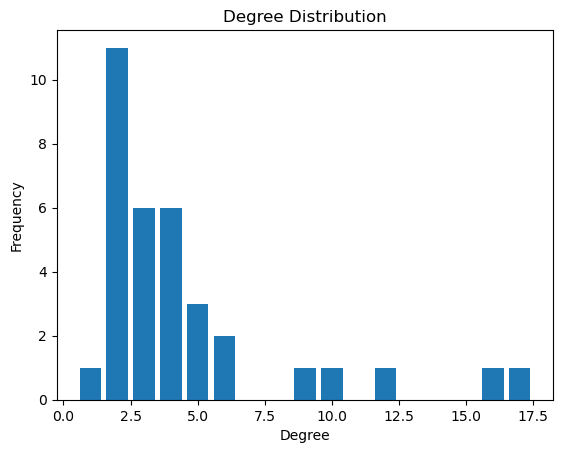

In [7]:
# degree distribution
import matplotlib.pyplot as plt


#This extracts the degree of each node in the graph.
#G.degree(n) returns the number of edges connected to node n.
#The result is a list of degrees for all nodes.


degrees = [G.degree(n) for n in G.nodes()]



# histogram
plt.hist(degrees, bins=range(1, max(degrees)+2), align='left', rwidth=0.8)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()


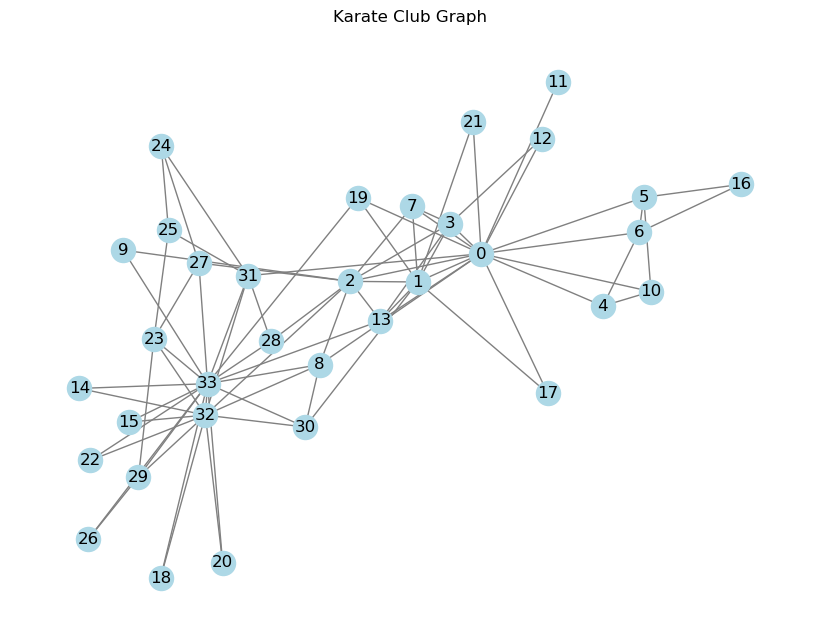

In [8]:
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray")
plt.title("Karate Club Graph")
plt.show()


In [9]:
type(G.nodes())

networkx.classes.reportviews.NodeView

In [10]:
G.nodes[1]

{'club': 'Mr. Hi'}

In [11]:
import networkx as nx

# Load dataset
G = nx.karate_club_graph()

# Print first 5 nodes with their attributes
for node, attrs in list(G.nodes(data=True))[:5]:
    print(f"Node {node}: {attrs}")


Node 0: {'club': 'Mr. Hi'}
Node 1: {'club': 'Mr. Hi'}
Node 2: {'club': 'Mr. Hi'}
Node 3: {'club': 'Mr. Hi'}
Node 4: {'club': 'Mr. Hi'}


In [12]:
# Print first 5 nodes and their connections
for node in list(G.nodes)[:5]:
    print(f"Node {node} (Club: {G.nodes[node]['club']}) is connected to: {list(G.neighbors(node))}")


Node 0 (Club: Mr. Hi) is connected to: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]
Node 1 (Club: Mr. Hi) is connected to: [0, 2, 3, 7, 13, 17, 19, 21, 30]
Node 2 (Club: Mr. Hi) is connected to: [0, 1, 3, 7, 8, 9, 13, 27, 28, 32]
Node 3 (Club: Mr. Hi) is connected to: [0, 1, 2, 7, 12, 13]
Node 4 (Club: Mr. Hi) is connected to: [0, 6, 10]


In [13]:
club_name = "Mr. Hi"  # Change to "Officer" to filter the other club

# Get nodes that belong to the selected club
club_members = [node for node in G.nodes if G.nodes[node]["club"] == club_name]

# Print a few members with their connections
for node in club_members[:5]:  # Show only the first 5 members
    print(f"Node {node} (Club: {G.nodes[node]['club']}) is connected to: {list(G.neighbors(node))}")


Node 0 (Club: Mr. Hi) is connected to: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]
Node 1 (Club: Mr. Hi) is connected to: [0, 2, 3, 7, 13, 17, 19, 21, 30]
Node 2 (Club: Mr. Hi) is connected to: [0, 1, 3, 7, 8, 9, 13, 27, 28, 32]
Node 3 (Club: Mr. Hi) is connected to: [0, 1, 2, 7, 12, 13]
Node 4 (Club: Mr. Hi) is connected to: [0, 6, 10]


To find the most connected members (nodes with the highest degree) in each club, we can:

Filter nodes by club
Sort them by degree (number of connections)
Display the top members for each club

In [14]:
# Find top members for each club
for club_name in ["Mr. Hi", "Officer"]:
    # Get nodes from the selected club
    club_members = [node for node in G.nodes if G.nodes[node]["club"] == club_name]
    
    # Sort members by degree (most connections first)
    sorted_members = sorted(club_members, key=lambda n: G.degree(n), reverse=True)
    
    # Print top 3 most connected members in this club
    print(f"\nTop 3 most connected members in '{club_name}' club:")
    for node in sorted_members[:3]:
        print(f"Node {node} - Degree: {G.degree(node)} - Connections: {list(G.neighbors(node))}")



Top 3 most connected members in 'Mr. Hi' club:
Node 0 - Degree: 16 - Connections: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]
Node 2 - Degree: 10 - Connections: [0, 1, 3, 7, 8, 9, 13, 27, 28, 32]
Node 1 - Degree: 9 - Connections: [0, 2, 3, 7, 13, 17, 19, 21, 30]

Top 3 most connected members in 'Officer' club:
Node 33 - Degree: 17 - Connections: [8, 9, 13, 14, 15, 18, 19, 20, 23, 26, 27, 28, 29, 30, 31, 32, 22]
Node 32 - Degree: 12 - Connections: [2, 8, 14, 15, 18, 20, 22, 23, 29, 30, 31, 33]
Node 31 - Degree: 6 - Connections: [0, 24, 25, 28, 32, 33]


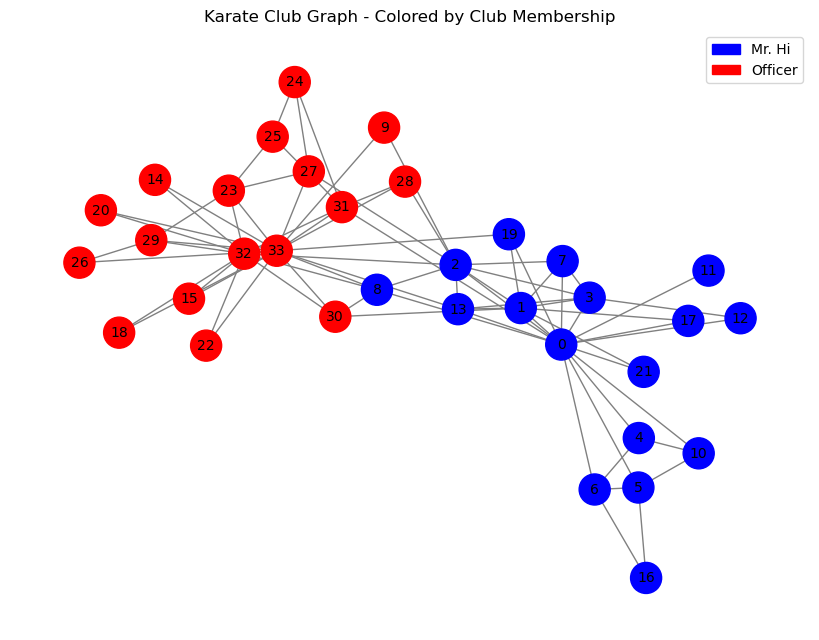

In [15]:

# Assign colors based on club membership
club_colors = {"Mr. Hi": "blue", "Officer": "red"}
node_colors = [club_colors[G.nodes[n]["club"]] for n in G.nodes]

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color=node_colors, edge_color="gray", node_size=500, font_size=10)

# Add a legend
from matplotlib.patches import Patch
legend_handles = [Patch(color=color, label=club) for club, color in club_colors.items()]
plt.legend(handles=legend_handles, loc="upper right")

plt.title("Karate Club Graph - Colored by Club Membership")
plt.show()

## Pre-processing

Since the Karate Club dataset is undirected, G.degree(n) just returns the total number of edges connected to node n (i.e., its degree). If we were working with a directed graph, we would need to use G.in_degree(n) for incoming edges and G.out_degree(n) for outgoing edges.

In [16]:
node_features = np.array([[G.degree(n)] for n in G.nodes])  # Each degree should be wrapped in a list
    # node_features will have shape (num_nodes, 1), which is compatible with the input layer.

In [17]:
node_features[:3]

array([[16],
       [ 9],
       [10]])

In [18]:
G = nx.karate_club_graph()
print(nx.get_edge_attributes(G, 'weight'))  # Should be an empty dictionary


{(0, 1): 4, (0, 2): 5, (0, 3): 3, (0, 4): 3, (0, 5): 3, (0, 6): 3, (0, 7): 2, (0, 8): 2, (0, 10): 2, (0, 11): 3, (0, 12): 1, (0, 13): 3, (0, 17): 2, (0, 19): 2, (0, 21): 2, (0, 31): 2, (1, 2): 6, (1, 3): 3, (1, 7): 4, (1, 13): 5, (1, 17): 1, (1, 19): 2, (1, 21): 2, (1, 30): 2, (2, 3): 3, (2, 7): 4, (2, 8): 5, (2, 9): 1, (2, 13): 3, (2, 27): 2, (2, 28): 2, (2, 32): 2, (3, 7): 3, (3, 12): 3, (3, 13): 3, (4, 6): 2, (4, 10): 3, (5, 6): 5, (5, 10): 3, (5, 16): 3, (6, 16): 3, (8, 30): 3, (8, 32): 3, (8, 33): 4, (9, 33): 2, (13, 33): 3, (14, 32): 3, (14, 33): 2, (15, 32): 3, (15, 33): 4, (18, 32): 1, (18, 33): 2, (19, 33): 1, (20, 32): 3, (20, 33): 1, (22, 32): 2, (22, 33): 3, (23, 25): 5, (23, 27): 4, (23, 29): 3, (23, 32): 5, (23, 33): 4, (24, 25): 2, (24, 27): 3, (24, 31): 2, (25, 31): 7, (26, 29): 4, (26, 33): 2, (27, 33): 4, (28, 31): 2, (28, 33): 2, (29, 32): 4, (29, 33): 2, (30, 32): 3, (30, 33): 3, (31, 32): 4, (31, 33): 4, (32, 33): 5}


In [21]:
# definición de esta matriz

# Prepare adjacency matrix
adj_matrix = nx.to_numpy_array(G) # weighted
#adj_matrix = (nx.to_numpy_array(G) > 0).astype(int)  # Converts all nonzero values to 1


In [22]:
adj_matrix

array([[0., 4., 5., ..., 2., 0., 0.],
       [4., 0., 6., ..., 0., 0., 0.],
       [5., 6., 0., ..., 0., 2., 0.],
       ...,
       [2., 0., 0., ..., 0., 4., 4.],
       [0., 0., 2., ..., 4., 0., 5.],
       [0., 0., 0., ..., 4., 5., 0.]])

In [23]:
adj_matrix.shape # 34x43 cant. de nodos; 1 si están relacionados

(34, 34)

In [24]:
# Prepare labels (node classification: which faction the user belongs to)
labels = np.array([G.nodes[n]['club'] == 'Mr. Hi' for n in G.nodes])  # 1 if in faction Mr. Hi, else 0

labels

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False, False,  True,  True,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [25]:
# Split dataset (simple 80-20 split for training and testing)
train_mask = np.zeros_like(labels, dtype=bool)
train_mask[:int(0.8 * len(labels))] = True


In [26]:
# Convert to Spektral Graph object
graph = Graph(x=node_features, a=adj_matrix, y=labels)

# Create a simple dataset for training
class KarateDataset(Dataset):
    def read(self):
        return [graph]

dataset = KarateDataset()

In [27]:
graph

Graph(n_nodes=34, n_node_features=1, n_edge_features=None, n_labels=34)

In [28]:
dataset

KarateDataset(n_graphs=1)

In [29]:
# training data

# Prepare training data
train_graph = dataset[0]
train_features = train_graph.x
train_adjacency = train_graph.a
train_labels = train_graph.y[train_mask]


print(train_features.shape), print(train_adjacency.shape), print(train_labels.shape)


(34, 1)
(34, 34)
(27,)


(None, None, None)

In [30]:
train_features = train_features[train_mask]  # Shape (27, 1)
train_adjacency = train_adjacency[train_mask][:, train_mask]  # Shape (27, 27)
train_labels = train_labels.reshape(-1, 1)  # Ensure it's (27, 1)

In [31]:
print(train_features.shape)   # Expected (27, 1)
print(train_adjacency.shape)  # Expected (27, 27)
print(train_labels.shape)     # Expected (27, 1)

(27, 1)
(27, 27)
(27, 1)


## Building the model

In [34]:
# Build the model (using previous code)
input_node_features = layers.Input(shape=(node_features.shape[1],))
#input_adjacency_matrix = layers.Input(shape=(node_features.shape[0], node_features.shape[0]))
input_adjacency_matrix = layers.Input(shape=(None, None))  # Dynamic adjacency shape


# Graph convolutional layers
x = GCNConv(64, activation='relu')([input_node_features, input_adjacency_matrix])
x = GCNConv(32, activation='relu')([x, input_adjacency_matrix])


# Fully connected layers for classification

x = layers.Dropout(0.5)(x)  # Add dropout before the dense layer
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)  # Binary classification (faction)

model = models.Model(inputs=[input_node_features, input_adjacency_matrix], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# Inputs
input_node_features = layers.Input(shape=(node_features.shape[1],))
input_adjacency_matrix = layers.Input(shape=(None, None))  # Dynamic adjacency shape

# Graph convolutional layers (reduced size)
x = GCNConv(32, activation='relu')([input_node_features, input_adjacency_matrix])
x = GCNConv(16, activation='relu')([x, input_adjacency_matrix])

# Fully connected layers for classification
x = layers.Dropout(0.3)(x)  # Lower dropout due to small dataset
x = layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
output = layers.Dense(1, activation='sigmoid')(x)  # Binary classification

# Build & Compile Model
model = models.Model(inputs=[input_node_features, input_adjacency_matrix], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, None, None)]         0         []                            
                                                                                                  
 gcn_conv_2 (GCNConv)        (None, None, 32)             64        ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 gcn_conv_3 (GCNConv)        (None, None, 16)             528       ['gcn_conv_2[0][0]',    

In [40]:
val_features = test_features
val_adjacency = test_adjacency
val_labels = test_labels

In [42]:
# Train the model
model.fit([train_features, train_adjacency], train_labels, 
          validation_data=([val_features, val_adjacency], val_labels),epochs=20)

Epoch 1/20
1/1 [==============================] - 0s 67ms/step - loss: 0.6228 - accuracy: 0.8889 - val_loss: 182.6489 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 26ms/step - loss: 2.0204 - accuracy: 0.7037 - val_loss: 184.0393 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 31ms/step - loss: 1.3677 - accuracy: 0.8148 - val_loss: 186.8070 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 29ms/step - loss: 1.6589 - accuracy: 0.7778 - val_loss: 188.5062 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 28ms/step - loss: 0.3392 - accuracy: 0.8889 - val_loss: 189.8965 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 28ms/step - loss: 4.3873 - accuracy: 0.8148 - val_loss: 188.7020 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 34ms/step - loss: 3.5883 - accuracy: 0.8148 - val_loss: 186.2088 - val_accura

In [93]:
train_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False])

In [94]:
test_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True])

In [95]:
train_adjacency

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 

In [96]:
test_adjacency

array([[0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 0]])

In [36]:
test_mask = ~train_mask  # Remaining 20% for testing

In [37]:
test_features = node_features[test_mask]    # Shape (7, 1)
test_labels = labels[test_mask].reshape(-1, 1)    # Shape (7, 1)

In [38]:
#
test_adjacency =  adj_matrix[test_mask][:, test_mask] 

In [39]:
test_features.shape, test_labels.shape, test_adjacency.shape

((7, 1), (7, 1), (7, 7))

In [132]:
# Evaluate model (returns loss and accuracy)
loss, accuracy = model.evaluate([test_features, test_adjacency], test_labels)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


1/1 [==============================] - 0s 18ms/step - loss: 0.2101 - accuracy: 1.0000
Test Loss: 0.2101
Test Accuracy: 1.0000


In [131]:
# Make predictions
predictions = model.predict([test_features, test_adjacency])

# Convert to binary classification (threshold at 0.5)
predictions = (predictions > 0.1).astype(int)

# Evaluate accuracy
accuracy = np.mean(predictions == test_labels)

# Print results
print("Predictions:", predictions.flatten())
print("True Labels:", test_labels.flatten())
print("Test Accuracy:", accuracy)

1/1 [==============================] - 0s 54ms/step
Predictions: [0 0 0 0 0 0 0]
True Labels: [False False False False False False False]
Test Accuracy: 1.0


In [ ]:

plt.scatter(np.arange(len(predictions)), predictions, label='Predictions')
plt.scatter(np.arange(len(test_labels)), test_labels, label='True Labels', alpha=0.6)
plt.legend()
plt.show()

### Predicting a node's club membership ("Mr. Hi" or "Officer") based on its connections.

In [50]:
adj

"""
normalize adj matrix

import scipy.sparse as sp

adj = nx.adjacency_matrix(G).astype(np.float32)
adj += sp.eye(adj.shape[0])  # Add self-loops
degree_matrix = np.array(adj.sum(axis=1)).flatten()
D_inv_sqrt = np.diag(1.0 / np.sqrt(degree_matrix))
adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt  # Symmetric normalization

adj = tf.convert_to_tensor(adj_normalized, dtype=tf.float32)


"""

'\nnormalize adj matrix\n\nimport scipy.sparse as sp\n\nadj = nx.adjacency_matrix(G).astype(np.float32)\nadj += sp.eye(adj.shape[0])  # Add self-loops\ndegree_matrix = np.array(adj.sum(axis=1)).flatten()\nD_inv_sqrt = np.diag(1.0 / np.sqrt(degree_matrix))\nadj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt  # Symmetric normalization\n\nadj = tf.convert_to_tensor(adj_normalized, dtype=tf.float32)\n\n\n'

Epoch 0, Loss: 95.07674407958984
Epoch 10, Loss: 0.05319088697433472
Epoch 20, Loss: 1.1617978811264038
Epoch 30, Loss: 0.9894177913665771
Epoch 40, Loss: 2.036013126373291
Epoch 50, Loss: 3.5061546554970846e-08
Epoch 60, Loss: 1.2502515316009521
Epoch 70, Loss: 0.062270332127809525
Epoch 80, Loss: 0.0
Epoch 90, Loss: 1.0763792991638184
Epoch 100, Loss: 1.3323376890639338e-07
Epoch 110, Loss: 0.00864916667342186
Epoch 120, Loss: 0.0010441920021548867
Epoch 130, Loss: 8.064102985372301e-07
Epoch 140, Loss: 0.0
Epoch 150, Loss: 0.0
Epoch 160, Loss: 0.6039879322052002
Epoch 170, Loss: 0.006938281934708357
Epoch 180, Loss: 0.38793158531188965
Epoch 190, Loss: 0.045562274754047394
Test Accuracy: 0.6470588445663452


/home/marcos/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/marcos/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


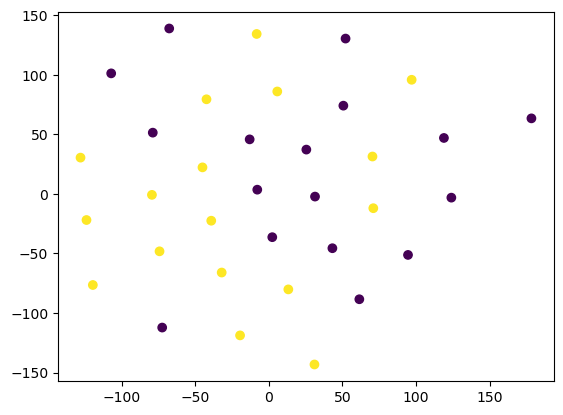

In [54]:
import tensorflow as tf
import numpy as np
import networkx as nx
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import StandardScaler

# 1. Load and preprocess the Karate Club dataset
G = nx.karate_club_graph()
adj = nx.adjacency_matrix(G).todense()



"""
import scipy.sparse as sp

adj = nx.adjacency_matrix(G).astype(np.float32)
adj += sp.eye(adj.shape[0])  # Add self-loops
degree_matrix = np.array(adj.sum(axis=1)).flatten()
D_inv_sqrt = np.diag(1.0 / np.sqrt(degree_matrix))
adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt  # Symmetric normalization

adj = tf.convert_to_tensor(adj_normalized, dtype=tf.float32)
"""




features = np.identity(len(G))  # Use identity matrix as initial features

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

labels = np.array([G.nodes[i]['club'] != 'Mr. Hi' for i in range(len(G))], dtype=np.int32)

# Create train and test masks (simplified for demonstration)
train_mask = np.zeros(len(G), dtype=bool)
train_mask[0:17] = True  # Arbitrary train/test split
test_mask = ~train_mask

# Convert data to TensorFlow tensors
adj = tf.convert_to_tensor(adj, dtype=tf.float32)
features = tf.convert_to_tensor(features, dtype=tf.float32)
labels = tf.convert_to_tensor(labels, dtype=tf.int32)
train_mask = tf.convert_to_tensor(train_mask)
test_mask = tf.convert_to_tensor(test_mask)

# 2. Define the GCN layer
class GCNLayer(Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # input_shape is a tuple of (features_shape, adj_shape)
        features_shape, _ = input_shape  # Unpack the tuple
        num_features = features_shape[-1] # Get the number of features from the features shape
        self.w = self.add_weight(shape=(num_features, self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        features, adj = inputs
        support = tf.matmul(features, self.w)
        adj_features = tf.matmul(adj, support)
        output = adj_features + self.b
        if self.activation:
            output = self.activation(output)
        return output

# 3. Define the GCN model
class GCNModel(tf.keras.Model):
    def __init__(self, hidden_units, num_classes):
        super(GCNModel, self).__init__()
        self.gcn1 = GCNLayer(hidden_units, activation='relu')
        self.gcn2 = GCNLayer(num_classes)

    def call(self, inputs):
        features, adj = inputs
        x = self.gcn1((features, adj))
        x = tf.nn.dropout(x, rate=0.5)
        x = self.gcn2((x, adj))
        return tf.nn.log_softmax(x, axis=1)

model = GCNModel(hidden_units=16, num_classes=2)

# 4. Define the loss function and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)



optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# 5. Training loop
epochs = 200
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        logits = model((features, adj))
        loss_value = loss_fn(labels[train_mask], logits[train_mask])
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}")

# 6. Evaluation
logits = model((features, adj))
predictions = tf.cast(tf.argmax(logits, axis=1), tf.int64) #added cast
correct_predictions = tf.equal(predictions[test_mask], tf.cast(labels[test_mask], tf.int64)) #added cast here too for safety
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
print(f"Test Accuracy: {accuracy.numpy()}")

# 7. (Optional) Visualization (requires matplotlib and sklearn)
try:
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE

    embeddings = model.gcn1((features,adj))
    embeddings = embeddings.numpy()

    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
    plt.show()

except ImportError:
    print("Visualization requires matplotlib and sklearn. Install them to visualize embeddings.")

In [45]:
labels

<tf.Tensor: shape=(34,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>

Epoch 0, Loss: 0.7417075634002686
Epoch 10, Loss: 0.3229388892650604
Epoch 20, Loss: 0.15869387984275818
Epoch 30, Loss: 0.12627078592777252
Epoch 40, Loss: 0.04664545878767967
Epoch 50, Loss: 0.03269624337553978
Epoch 60, Loss: 0.056192733347415924
Epoch 70, Loss: 0.015738531947135925
Epoch 80, Loss: 0.01905663311481476
Epoch 90, Loss: 0.017489472404122353
Epoch 100, Loss: 0.017424026504158974
Epoch 110, Loss: 0.0051550474017858505
Epoch 120, Loss: 0.005129312165081501
Epoch 130, Loss: 0.013614985160529613
Epoch 140, Loss: 0.014903934672474861
Epoch 150, Loss: 0.034706395119428635
Epoch 160, Loss: 0.045869212597608566
Epoch 170, Loss: 0.014335288666188717
Epoch 180, Loss: 0.00014642502355854958
Epoch 190, Loss: 0.011366779915988445
Test Accuracy: 0.9411764740943909


/home/marcos/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/marcos/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


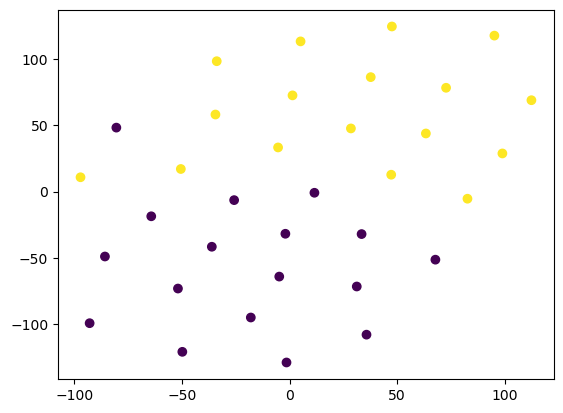

In [55]:
import tensorflow as tf
import numpy as np
import networkx as nx
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp

# Load and preprocess the Karate Club dataset
G = nx.karate_club_graph()

adj = nx.adjacency_matrix(G).astype(np.float32).todense()  # Ensure it's dense
adj += np.eye(adj.shape[0])  # Add self-loops
degree_matrix = np.array(adj.sum(axis=1)).flatten()
D_inv_sqrt = np.diag(1.0 / np.sqrt(degree_matrix))
adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt  # Symmetric normalization

adj = tf.convert_to_tensor(adj_normalized, dtype=tf.float32)

features = np.identity(len(G))  # Identity matrix as features
scaler = StandardScaler()
features = scaler.fit_transform(features)

labels = np.array([G.nodes[i]['club'] != 'Mr. Hi' for i in range(len(G))], dtype=np.int32)

train_mask = np.zeros(len(G), dtype=bool)
train_mask[0:17] = True  
test_mask = ~train_mask

# Convert to TensorFlow tensors
features = tf.convert_to_tensor(features, dtype=tf.float32)
labels = tf.convert_to_tensor(labels, dtype=tf.int32)
train_mask = tf.convert_to_tensor(train_mask)
test_mask = tf.convert_to_tensor(test_mask)

# Define GCN Layer
class GCNLayer(Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        features_shape, _ = input_shape  
        num_features = features_shape[-1]
        self.w = self.add_weight(shape=(num_features, self.units), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)

    def call(self, inputs):
        features, adj = inputs
        support = tf.matmul(features, self.w)
        adj_features = tf.matmul(adj, support)
        output = adj_features + self.b
        if self.activation:
            output = self.activation(output)
        return output

# Define GCN Model
class GCNModel(tf.keras.Model):
    def __init__(self, hidden_units, num_classes):
        super(GCNModel, self).__init__()
        self.gcn1 = GCNLayer(hidden_units, activation='relu')
        self.gcn2 = GCNLayer(num_classes)

    def call(self, inputs):
        features, adj = inputs
        x = self.gcn1((features, adj))
        x = tf.nn.dropout(x, rate=0.5)
        x = self.gcn2((x, adj))
        return tf.nn.log_softmax(x, axis=1)

model = GCNModel(hidden_units=16, num_classes=2)

# Loss and Optimizer
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  # Corrected
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Training loop
epochs = 200
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        logits = model((features, adj))
        loss_value = loss(labels[train_mask], logits[train_mask])  # Fixed loss_fn name
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}")

# Evaluation
logits = model((features, adj))
predictions = tf.cast(tf.argmax(logits, axis=1), tf.int64)
correct_predictions = tf.equal(predictions[test_mask], tf.cast(labels[test_mask], tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
print(f"Test Accuracy: {accuracy.numpy()}")

# Optional Visualization
try:
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE

    embeddings = model.gcn1((features, adj)).numpy()
    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
    plt.show()

except ImportError:
    print("Visualization requires matplotlib and sklearn.")


In [58]:
logits = model((features, adj))
logits

<tf.Tensor: shape=(34, 2), dtype=float32, numpy=
array([[ 0.00000000e+00, -3.16098442e+01],
       [ 0.00000000e+00, -2.11140633e+01],
       [ 0.00000000e+00, -1.83206367e+01],
       [-1.19209275e-07, -1.64608307e+01],
       [-3.57627783e-07, -1.49324780e+01],
       [ 0.00000000e+00, -2.11037865e+01],
       [ 0.00000000e+00, -2.47584133e+01],
       [ 0.00000000e+00, -1.76720123e+01],
       [-5.99017087e-03, -5.12063265e+00],
       [-1.73156846e+00, -1.94807082e-01],
       [ 0.00000000e+00, -1.87837849e+01],
       [-4.88746155e-05, -9.92644978e+00],
       [-1.32321429e-05, -1.12319469e+01],
       [ 0.00000000e+00, -1.67477837e+01],
       [-6.31974077e+00, -1.80201198e-03],
       [-6.46025372e+00, -1.56566070e-03],
       [-1.19209275e-07, -1.63947105e+01],
       [-6.91411469e-06, -1.18855886e+01],
       [-3.25781631e+00, -3.92319113e-02],
       [-2.33647479e-05, -1.06667118e+01],
       [-4.31389189e+00, -1.34716481e-02],
       [-7.15255510e-07, -1.41583757e+01],
     

In [56]:
# Get model predictions (log-softmax outputs)
logits = model((features, adj))  # Shape: (num_nodes, num_classes)

# Convert log-softmax to class predictions (argmax)
predictions = tf.argmax(logits, axis=1)  # Shape: (num_nodes,)

# Example: Predict the class of node 5
node_id = 5
predicted_class = predictions[node_id].numpy()

print(f"Predicted class for node {node_id}: {predicted_class}")


Predicted class for node 5: 0


In [57]:
true_class = labels[node_id].numpy()
print(f"True class for node {node_id}: {true_class}")


True class for node 5: 0


In [ ]:
#https://towardsdatascience.com/softmax-activation-function-how-it-actually-works-d292d335bd78/

Epoch 0, Loss: 0.6931471824645996
Epoch 10, Loss: 0.6931471824645996
Epoch 20, Loss: 0.6931471824645996
Epoch 30, Loss: 0.6931471824645996
Epoch 40, Loss: 0.6931471824645996
Epoch 50, Loss: 0.6931471824645996
Epoch 60, Loss: 0.6931471824645996
Epoch 70, Loss: 0.6931471824645996
Epoch 80, Loss: 0.6931471824645996
Epoch 90, Loss: 0.6931471824645996
Epoch 100, Loss: 0.6931471824645996
Epoch 110, Loss: 0.6931471824645996
Epoch 120, Loss: 0.6931471824645996
Epoch 130, Loss: 0.6931471824645996
Epoch 140, Loss: 0.6931471824645996
Epoch 150, Loss: 0.6931471824645996
Epoch 160, Loss: 0.6931471824645996
Epoch 170, Loss: 0.6931471824645996
Epoch 180, Loss: 0.6931471824645996
Epoch 190, Loss: 0.6931471824645996
Test Accuracy: 0.1764705926179886


/home/marcos/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/marcos/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


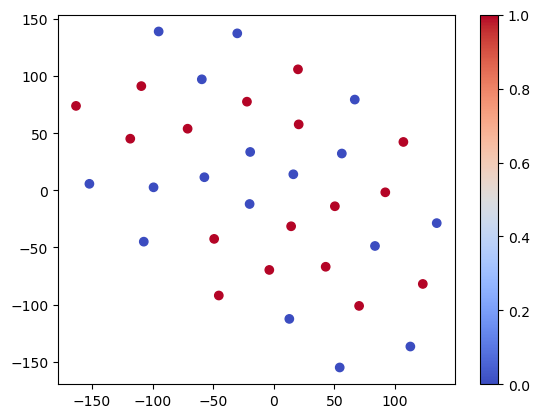

In [59]:
import tensorflow as tf
import numpy as np
import networkx as nx
import scipy.sparse as sp
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import StandardScaler

# 1. Load and preprocess the Karate Club dataset
G = nx.karate_club_graph()

# Compute adjacency matrix and normalize it
adj = nx.adjacency_matrix(G).astype(np.float32)
adj += sp.eye(adj.shape[0])  # Add self-loops
degree_matrix = np.array(adj.sum(axis=1)).flatten()
D_inv_sqrt = np.diag(1.0 / np.sqrt(degree_matrix))
adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt  # Symmetric normalization

adj = tf.convert_to_tensor(adj_normalized, dtype=tf.float32)

# Compute node degree as features
degrees = np.array([G.degree(n) for n in G.nodes()], dtype=np.float32).reshape(-1, 1)

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(degrees)

# Convert labels (0 for 'Mr. Hi' club, 1 for 'Officer' club)
labels = np.array([G.nodes[i]['club'] != 'Mr. Hi' for i in range(len(G))], dtype=np.int32)

# Create train and test masks (simplified split)
train_mask = np.zeros(len(G), dtype=bool)
train_mask[0:17] = True  # First 17 nodes for training
test_mask = ~train_mask

# Convert data to TensorFlow tensors
features = tf.convert_to_tensor(features, dtype=tf.float32)
labels = tf.convert_to_tensor(labels, dtype=tf.int32)
train_mask = tf.convert_to_tensor(train_mask)
test_mask = tf.convert_to_tensor(test_mask)

# 2. Define the GCN layer
class GCNLayer(Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        num_features = input_shape[0][-1]  # Number of input features
        self.w = self.add_weight(shape=(num_features, self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        features, adj = inputs
        support = tf.matmul(features, self.w)
        adj_features = tf.matmul(adj, support)
        output = adj_features + self.b
        return self.activation(output) if self.activation else output

# 3. Define the GCN model
class GCNModel(tf.keras.Model):
    def __init__(self, hidden_units, num_classes):
        super(GCNModel, self).__init__()
        self.gcn1 = GCNLayer(hidden_units, activation='relu')
        self.gcn2 = GCNLayer(num_classes)

    def call(self, inputs):
        features, adj = inputs
        x = self.gcn1((features, adj))
        x = tf.nn.dropout(x, rate=0.5)
        x = self.gcn2((x, adj))
        return tf.nn.log_softmax(x, axis=1)  # Output log-softmax for classification

model = GCNModel(hidden_units=16, num_classes=2)

# 4. Define the loss function and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)  # Log-softmax output
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# 5. Training loop
epochs = 200
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        logits = model((features, adj))
        loss_value = loss_fn(labels[train_mask], logits[train_mask])
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}")

# 6. Evaluation
logits = model((features, adj))
predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
correct_predictions = tf.equal(predictions[test_mask], labels[test_mask])
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
print(f"Test Accuracy: {accuracy.numpy()}")

# 7. (Optional) Visualization
try:
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE

    embeddings = model.gcn1((features, adj)).numpy()
    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels.numpy(), cmap='coolwarm')
    plt.colorbar()
    plt.show()

except ImportError:
    print("Visualization requires matplotlib and sklearn. Install them to visualize embeddings.")


Epoch 0, Loss: 0.6260215044021606
Epoch 10, Loss: 0.40955856442451477
Epoch 20, Loss: 0.2578500211238861
Epoch 30, Loss: 0.21667346358299255
Epoch 40, Loss: 0.15858328342437744
Epoch 50, Loss: 0.13455383479595184
Epoch 60, Loss: 0.11263490468263626
Epoch 70, Loss: 0.10456793755292892
Epoch 80, Loss: 0.07293979078531265
Epoch 90, Loss: 0.10416360944509506
Epoch 100, Loss: 0.06018536910414696
Epoch 110, Loss: 0.08503933995962143
Epoch 120, Loss: 0.04991859570145607
Epoch 130, Loss: 0.05961369723081589
Epoch 140, Loss: 0.05328712612390518
Epoch 150, Loss: 0.08404215425252914
Epoch 160, Loss: 0.06341034173965454
Epoch 170, Loss: 0.06004537642002106
Epoch 180, Loss: 0.04123087227344513
Epoch 190, Loss: 0.05092784762382507
Test Accuracy: 0.9411764740943909


/home/marcos/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/marcos/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


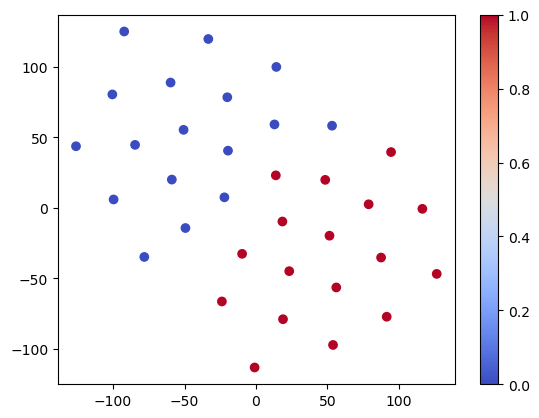

In [62]:
import tensorflow as tf
import numpy as np
import networkx as nx
import scipy.sparse as sp
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import OneHotEncoder

# 1. Load and preprocess the Karate Club dataset
G = nx.karate_club_graph()

# Compute adjacency matrix and normalize it
adj = nx.adjacency_matrix(G).astype(np.float32)
adj += sp.eye(adj.shape[0])  # Add self-loops
degree_matrix = np.array(adj.sum(axis=1)).flatten()
D_inv_sqrt = np.diag(1.0 / np.sqrt(degree_matrix))
adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt  # Symmetric normalization

adj = tf.convert_to_tensor(adj_normalized, dtype=tf.float32)

# Use community labels ('Mr. Hi' or 'Officer') as one-hot encoded features
communities = np.array([G.nodes[i]['club'] for i in range(len(G))]).reshape(-1, 1)
encoder = OneHotEncoder(sparse=False, dtype=np.float32)
features = encoder.fit_transform(communities)

# Convert labels (0 for 'Mr. Hi' club, 1 for 'Officer' club)
labels = np.array([G.nodes[i]['club'] != 'Mr. Hi' for i in range(len(G))], dtype=np.int32)

# Create train and test masks (simplified split)
train_mask = np.zeros(len(G), dtype=bool)
train_mask[0:17] = True  # First 17 nodes for training
test_mask = ~train_mask

# Convert data to TensorFlow tensors
features = tf.convert_to_tensor(features, dtype=tf.float32)
labels = tf.convert_to_tensor(labels, dtype=tf.int32)
train_mask = tf.convert_to_tensor(train_mask)
test_mask = tf.convert_to_tensor(test_mask)

# 2. Define the GCN layer
class GCNLayer(Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        num_features = input_shape[0][-1]  # Number of input features
        self.w = self.add_weight(shape=(num_features, self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        features, adj = inputs
        support = tf.matmul(features, self.w)
        adj_features = tf.matmul(adj, support)
        output = adj_features + self.b
        return self.activation(output) if self.activation else output

# 3. Define the GCN model
class GCNModel(tf.keras.Model):
    def __init__(self, hidden_units, num_classes):
        super(GCNModel, self).__init__()
        self.gcn1 = GCNLayer(hidden_units, activation='relu')
        self.gcn2 = GCNLayer(num_classes)

    def call(self, inputs):
        features, adj = inputs
        x = self.gcn1((features, adj))
        x = tf.nn.dropout(x, rate=0.5)
        x = self.gcn2((x, adj))
        return tf.nn.log_softmax(x, axis=1)  # Output log-softmax for classification

model = GCNModel(hidden_units=16, num_classes=2)

# 4. Define the loss function and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  # Log-softmax output
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# 5. Training loop
epochs = 200
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        logits = model((features, adj))
        loss_value = loss_fn(labels[train_mask], logits[train_mask])
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}")

# 6. Evaluation
logits = model((features, adj))
predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
correct_predictions = tf.equal(predictions[test_mask], labels[test_mask])
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
print(f"Test Accuracy: {accuracy.numpy()}")

# 7. (Optional) Visualization
try:
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE

    embeddings = model.gcn1((features, adj)).numpy()
    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels.numpy(), cmap='coolwarm')
    plt.colorbar()
    plt.show()

except ImportError:
    print("Visualization requires matplotlib and sklearn. Install them to visualize embeddings.")


In [65]:
logits = model((features, adj))
logits

<tf.Tensor: shape=(34, 2), dtype=float32, numpy=
array([[ 0.00000000e+00, -1.79146976e+01],
       [-4.76837045e-07, -1.45950699e+01],
       [-2.47952248e-05, -1.06054420e+01],
       [-8.58303247e-06, -1.16589079e+01],
       [-4.20720258e-04, -7.77381325e+00],
       [-7.41454351e-05, -9.50987339e+00],
       [-2.02655565e-06, -1.30860662e+01],
       [-5.73380203e-05, -9.76583290e+00],
       [-2.28908490e-02, -3.78843951e+00],
       [-5.72925806e-01, -8.29822421e-01],
       [-1.28745205e-05, -1.12601633e+01],
       [-1.72168750e-03, -6.36528492e+00],
       [-3.54602304e-03, -5.64370489e+00],
       [-8.48734126e-05, -9.37500191e+00],
       [-2.20495272e+00, -1.16821274e-01],
       [-2.19989491e+00, -1.17449731e-01],
       [-6.23389496e-04, -7.38059568e+00],
       [-3.45051347e-04, -7.97206974e+00],
       [-1.82736504e+00, -1.75350040e-01],
       [-9.50480578e-04, -6.95905972e+00],
       [-1.96851778e+00, -1.50431976e-01],
       [-5.16757951e-04, -7.56825399e+00],
     

In [63]:
# Get model predictions
logits = model((features, adj))
predictions = tf.argmax(logits, axis=1, output_type=tf.int32)

# Print predictions for all nodes
for node, pred in enumerate(predictions.numpy()):
    print(f"Node {node}: Predicted class {pred}")

node_id = 5  # Change this to any node ID
print(f"Node {node_id}: Predicted class {predictions[node_id].numpy()}")

Node 0: Predicted class 0
Node 1: Predicted class 0
Node 2: Predicted class 0
Node 3: Predicted class 0
Node 4: Predicted class 0
Node 5: Predicted class 0
Node 6: Predicted class 0
Node 7: Predicted class 0
Node 8: Predicted class 0
Node 9: Predicted class 1
Node 10: Predicted class 0
Node 11: Predicted class 0
Node 12: Predicted class 0
Node 13: Predicted class 0
Node 14: Predicted class 1
Node 15: Predicted class 1
Node 16: Predicted class 0
Node 17: Predicted class 0
Node 18: Predicted class 1
Node 19: Predicted class 0
Node 20: Predicted class 1
Node 21: Predicted class 0
Node 22: Predicted class 1
Node 23: Predicted class 1
Node 24: Predicted class 1
Node 25: Predicted class 1
Node 26: Predicted class 1
Node 27: Predicted class 1
Node 28: Predicted class 1
Node 29: Predicted class 1
Node 30: Predicted class 0
Node 31: Predicted class 1
Node 32: Predicted class 1
Node 33: Predicted class 1
Node 5: Predicted class 0


In [88]:
import tensorflow as tf
import numpy as np
import networkx as nx
import scipy.sparse as sp
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import StandardScaler

# Load the Karate Club dataset
G = nx.karate_club_graph()
num_nodes = len(G)

# Compute adjacency matrix and normalize it
adj = nx.adjacency_matrix(G).astype(np.float32)
adj += sp.eye(adj.shape[0])  # Add self-loops
degree_matrix = np.array(adj.sum(axis=1)).flatten()
D_inv_sqrt = np.diag(1.0 / np.sqrt(degree_matrix))
adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt
adj = tf.convert_to_tensor(adj_normalized, dtype=tf.float32)

# One-hot encoding for node features
features = np.eye(num_nodes, dtype=np.float32)
features = tf.convert_to_tensor(features, dtype=tf.float32)

# Convert labels (0 for 'Mr. Hi' club, 1 for 'Officer' club)
labels = np.array([G.nodes[i]['club'] != 'Mr. Hi' for i in range(num_nodes)], dtype=np.int32)

# Train/test split
train_mask = np.zeros(num_nodes, dtype=bool)
train_mask[:17] = True  # First 17 nodes for training
test_mask = ~train_mask
train_mask = tf.convert_to_tensor(train_mask)
test_mask = tf.convert_to_tensor(test_mask)

# Define GCN layer with L2 regularization
class GCNLayer(Layer):
    def __init__(self, units, activation=None, l2_reg=1e-3, **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.l2_reg = l2_reg

    def build(self, input_shape):
        num_features = input_shape[0][-1]
        self.w = self.add_weight(shape=(num_features, self.units),
                                 initializer='glorot_uniform',
                                 regularizer=tf.keras.regularizers.l2(self.l2_reg),
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        features, adj = inputs
        support = tf.matmul(features, self.w)
        adj_features = tf.matmul(adj, support)
        output = adj_features + self.b
        return self.activation(output) if self.activation else output

# Define GCN Model with reduced dropout
class GCNModel(tf.keras.Model):
    def __init__(self, hidden_units, num_classes, dropout_rate=0.2):
        super(GCNModel, self).__init__()
        self.gcn1 = GCNLayer(hidden_units, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.gcn2 = GCNLayer(num_classes)  # Raw logits
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.batch_norm = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training=False):
        features, adj = inputs
        x = self.gcn1((features, adj))
        x = self.batch_norm(x, training=training)
        x = self.dropout1(x, training=training)
        x = self.gcn2((x, adj))
        x = self.dropout2(x, training=training)
        return x

# Instantiate model
model = GCNModel(hidden_units=16, num_classes=2, dropout_rate=0.2)

# Define loss function and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Training loop with early stopping
epochs = 500
best_accuracy = 0
patience = 20
wait = 0

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        logits = model((features, adj), training=True)
        loss_value = loss_fn(labels[train_mask], logits[train_mask])

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Compute test accuracy
    logits = model((features, adj), training=False)
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    correct_predictions = tf.equal(predictions[test_mask], labels[test_mask])
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32)).numpy()

    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
    
    """
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        wait = 0
    else:
        wait += 1

    if wait >= patience:
        print("Early stopping triggered")
        break
    """

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}, Test Accuracy: {accuracy}")

print(f"Final Test Accuracy: {best_accuracy}")


Epoch 0, Loss: 0.9658761024475098, Test Accuracy: 0.4117647111415863
Epoch 10, Loss: 0.29389649629592896, Test Accuracy: 0.1764705926179886
Epoch 20, Loss: 0.19180291891098022, Test Accuracy: 0.1764705926179886
Epoch 30, Loss: 0.10114803165197372, Test Accuracy: 0.1764705926179886
Epoch 40, Loss: 0.15556323528289795, Test Accuracy: 0.1764705926179886
Epoch 50, Loss: 0.09631139785051346, Test Accuracy: 0.1764705926179886
Epoch 60, Loss: 0.1620120108127594, Test Accuracy: 0.1764705926179886
Epoch 70, Loss: 0.11092886328697205, Test Accuracy: 0.1764705926179886
Epoch 80, Loss: 0.04231027886271477, Test Accuracy: 0.1764705926179886
Epoch 90, Loss: 0.07896269112825394, Test Accuracy: 0.1764705926179886
Epoch 100, Loss: 0.06178728863596916, Test Accuracy: 0.1764705926179886
Epoch 110, Loss: 0.011882925406098366, Test Accuracy: 0.1764705926179886
Epoch 120, Loss: 0.01847132295370102, Test Accuracy: 0.1764705926179886
Epoch 130, Loss: 0.005766233429312706, Test Accuracy: 0.1764705926179886
Epo

This code uses two types of node features:

One-hot encoding: Each node gets a unique binary vector where only one element is 1, indicating its index.
Node degree: The number of edges connected to each node, normalized using StandardScaler().
This adds some structural information to the features, helping the model distinguish nodes based on their connectivity.


Yes, this feature set differentiates nodes based on:

Structure (Uniqueness of Nodes) – The one-hot encoding ensures that each node has a distinct representation, helping the model distinguish them.
Number of Ingoing Edges (Degree Centrality) – The degree feature captures how many connections (edges) each node has, reflecting its importance in the network.
However, the degree feature in an undirected graph (like Karate Club) represents both ingoing and outgoing edges, since all edges are bidirectional. If you want to distinguish between ingoing vs. outgoing edges, you’d need a directed graph and compute in-degree and out-degree separately.

Would you like to try more features, such as clustering coefficient, betweenness centrality, or personalized PageRank? These could help the model learn better!

In [90]:
import tensorflow as tf
import numpy as np
import networkx as nx
import scipy.sparse as sp
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import StandardScaler

# Load the Karate Club dataset
G = nx.karate_club_graph()
num_nodes = len(G)

# Compute adjacency matrix and normalize it
adj = nx.adjacency_matrix(G).astype(np.float32)
adj += sp.eye(adj.shape[0])  # Add self-loops
degree_matrix = np.array(adj.sum(axis=1)).flatten()
D_inv_sqrt = np.diag(1.0 / np.sqrt(degree_matrix))
adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt
adj = tf.convert_to_tensor(adj_normalized, dtype=tf.float32)

# One-hot encoding for node features
one_hot_features = np.eye(num_nodes, dtype=np.float32)

# Compute node degree
degrees = np.array([G.degree(n) for n in G.nodes()], dtype=np.float32).reshape(-1, 1)
scaler = StandardScaler()
degrees = scaler.fit_transform(degrees)

# Concatenate one-hot encoding with degree
features = np.concatenate([one_hot_features, degrees], axis=1)
features = tf.convert_to_tensor(features, dtype=tf.float32)

# Convert labels (0 for 'Mr. Hi' club, 1 for 'Officer' club)
labels = np.array([G.nodes[i]['club'] != 'Mr. Hi' for i in range(num_nodes)], dtype=np.int32)

# Train/test split
train_mask = np.zeros(num_nodes, dtype=bool)
train_mask[:17] = True  # First 17 nodes for training
test_mask = ~train_mask
train_mask = tf.convert_to_tensor(train_mask)
test_mask = tf.convert_to_tensor(test_mask)

# Define GCN layer with L2 regularization
class GCNLayer(Layer):
    def __init__(self, units, activation=None, l2_reg=1e-3, **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.l2_reg = l2_reg

    def build(self, input_shape):
        num_features = input_shape[0][-1]
        self.w = self.add_weight(shape=(num_features, self.units),
                                 initializer='glorot_uniform',
                                 regularizer=tf.keras.regularizers.l2(self.l2_reg),
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        features, adj = inputs
        support = tf.matmul(features, self.w)
        adj_features = tf.matmul(adj, support)
        output = adj_features + self.b
        return self.activation(output) if self.activation else output

# Define GCN Model with reduced dropout
class GCNModel(tf.keras.Model):
    def __init__(self, hidden_units, num_classes, dropout_rate=0.2):
        super(GCNModel, self).__init__()
        self.gcn1 = GCNLayer(hidden_units, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.gcn2 = GCNLayer(num_classes)  # Raw logits
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.batch_norm = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training=False):
        features, adj = inputs
        x = self.gcn1((features, adj))
        x = self.batch_norm(x, training=training)
        x = self.dropout1(x, training=training)
        x = self.gcn2((x, adj))
        x = self.dropout2(x, training=training)
        return x

# Instantiate model
model = GCNModel(hidden_units=16, num_classes=2, dropout_rate=0.2)

# Define loss function and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Training loop with early stopping
epochs = 500
best_accuracy = 0
patience = 20
wait = 0

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        logits = model((features, adj), training=True)
        loss_value = loss_fn(labels[train_mask], logits[train_mask])

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Compute test accuracy
    logits = model((features, adj), training=False)
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    correct_predictions = tf.equal(predictions[test_mask], labels[test_mask])
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32)).numpy()

    if accuracy > best_accuracy:
        best_accuracy = accuracy

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}, Test Accuracy: {accuracy}")

print(f"Final Test Accuracy: {best_accuracy}")


Epoch 0, Loss: 0.6188504695892334, Test Accuracy: 0.8235294222831726
Epoch 10, Loss: 0.20591221749782562, Test Accuracy: 0.6470588445663452
Epoch 20, Loss: 0.1480216234922409, Test Accuracy: 0.29411765933036804
Epoch 30, Loss: 0.09220340102910995, Test Accuracy: 0.23529411852359772
Epoch 40, Loss: 0.23677298426628113, Test Accuracy: 0.23529411852359772
Epoch 50, Loss: 0.05336316302418709, Test Accuracy: 0.29411765933036804
Epoch 60, Loss: 0.040404606610536575, Test Accuracy: 0.29411765933036804
Epoch 70, Loss: 0.10469454526901245, Test Accuracy: 0.29411765933036804
Epoch 80, Loss: 0.05522683262825012, Test Accuracy: 0.29411765933036804
Epoch 90, Loss: 0.05661575496196747, Test Accuracy: 0.3529411852359772
Epoch 100, Loss: 0.050229281187057495, Test Accuracy: 0.4117647111415863
Epoch 110, Loss: 0.011436465196311474, Test Accuracy: 0.4117647111415863
Epoch 120, Loss: 0.04438059404492378, Test Accuracy: 0.47058823704719543
Epoch 130, Loss: 0.05011783540248871, Test Accuracy: 0.47058823704

In [91]:
import tensorflow as tf
import numpy as np
import networkx as nx
import scipy.sparse as sp
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import StandardScaler

# Load the Karate Club dataset
G = nx.karate_club_graph()
num_nodes = len(G)

# Compute adjacency matrix and normalize it
adj = nx.adjacency_matrix(G).astype(np.float32)
adj += sp.eye(adj.shape[0])  # Add self-loops
degree_matrix = np.array(adj.sum(axis=1)).flatten()
D_inv_sqrt = np.diag(1.0 / np.sqrt(degree_matrix))
adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt
adj = tf.convert_to_tensor(adj_normalized, dtype=tf.float32)

# Compute node features
one_hot_features = np.eye(num_nodes, dtype=np.float32)
degrees = np.array([G.degree(n) for n in G.nodes()], dtype=np.float32).reshape(-1, 1)
clustering_coeffs = np.array([nx.clustering(G, n) for n in G.nodes()], dtype=np.float32).reshape(-1, 1)
betweenness = np.array(list(nx.betweenness_centrality(G).values()), dtype=np.float32).reshape(-1, 1)
pagerank = np.array(list(nx.pagerank(G).values()), dtype=np.float32).reshape(-1, 1)

# Standardize numerical features
scaler = StandardScaler()
numeric_features = scaler.fit_transform(np.hstack([degrees, clustering_coeffs, betweenness, pagerank]))

# Concatenate all features
features = np.hstack([one_hot_features, numeric_features])
features = tf.convert_to_tensor(features, dtype=tf.float32)

# Convert labels (0 for 'Mr. Hi' club, 1 for 'Officer' club)
labels = np.array([G.nodes[i]['club'] != 'Mr. Hi' for i in range(num_nodes)], dtype=np.int32)

# Train/test split
train_mask = np.zeros(num_nodes, dtype=bool)
train_mask[:17] = True  # First 17 nodes for training
test_mask = ~train_mask
train_mask = tf.convert_to_tensor(train_mask)
test_mask = tf.convert_to_tensor(test_mask)

# Define GCN layer
class GCNLayer(Layer):
    def __init__(self, units, activation=None, l2_reg=1e-3, **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.l2_reg = l2_reg

    def build(self, input_shape):
        num_features = input_shape[0][-1]
        self.w = self.add_weight(shape=(num_features, self.units),
                                 initializer='glorot_uniform',
                                 regularizer=tf.keras.regularizers.l2(self.l2_reg),
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)

    def call(self, inputs):
        features, adj = inputs
        support = tf.matmul(features, self.w)
        adj_features = tf.matmul(adj, support)
        output = adj_features + self.b
        return self.activation(output) if self.activation else output

# Define GCN Model
class GCNModel(tf.keras.Model):
    def __init__(self, hidden_units, num_classes, dropout_rate=0.2):
        super(GCNModel, self).__init__()
        self.gcn1 = GCNLayer(hidden_units, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.gcn2 = GCNLayer(num_classes)  # Raw logits
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.batch_norm = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training=False):
        features, adj = inputs
        x = self.gcn1((features, adj))
        x = self.batch_norm(x, training=training) # dropout is equal true only for training
        x = self.dropout1(x, training=training)
        x = self.gcn2((x, adj))
        x = self.dropout2(x, training=training)
        return x

# Instantiate model
model = GCNModel(hidden_units=16, num_classes=2, dropout_rate=0.2)

# Define loss function and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Training loop
epochs = 500
best_accuracy = 0
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        logits = model((features, adj), training=True)
        loss_value = loss_fn(labels[train_mask], logits[train_mask])
    
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Compute test accuracy
    logits = model((features, adj), training=False)
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    correct_predictions = tf.equal(predictions[test_mask], labels[test_mask])
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32)).numpy()

    if accuracy > best_accuracy:
        best_accuracy = accuracy

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}, Test Accuracy: {accuracy}")

print(f"Final Test Accuracy: {best_accuracy}")


Epoch 0, Loss: 0.8277952671051025, Test Accuracy: 0.8235294222831726
Epoch 10, Loss: 0.2788771688938141, Test Accuracy: 0.29411765933036804
Epoch 20, Loss: 0.1691722869873047, Test Accuracy: 0.1764705926179886
Epoch 30, Loss: 0.12330774962902069, Test Accuracy: 0.1764705926179886
Epoch 40, Loss: 0.146169513463974, Test Accuracy: 0.1764705926179886
Epoch 50, Loss: 0.0760304257273674, Test Accuracy: 0.1764705926179886
Epoch 60, Loss: 0.09054353833198547, Test Accuracy: 0.1764705926179886
Epoch 70, Loss: 0.04319975897669792, Test Accuracy: 0.1764705926179886
Epoch 80, Loss: 0.05221278592944145, Test Accuracy: 0.1764705926179886
Epoch 90, Loss: 0.11351022869348526, Test Accuracy: 0.1764705926179886
Epoch 100, Loss: 0.08539934456348419, Test Accuracy: 0.1764705926179886
Epoch 110, Loss: 0.04930278658866882, Test Accuracy: 0.1764705926179886
Epoch 120, Loss: 0.07640104740858078, Test Accuracy: 0.1764705926179886
Epoch 130, Loss: 0.04928115755319595, Test Accuracy: 0.1764705926179886
Epoch 14

""""
If the model performs significantly better with from_logits=False, it's likely because the logits (raw scores) are already well-distributed, and applying an additional softmax inside the loss function helps stabilize training. However, conceptually, if the model outputs raw logits, from_logits=True is the correct setting.

You can check if the outputs are logits or probabilities:

python
Copiar
Editar
logits = model((features, adj))
print(tf.reduce_min(logits), tf.reduce_max(logits))
If values are unbounded (e.g., negative and positive large values), they are logits.
If values are between 0 and 1 and sum to 1 across classes, they are probabilities.
If the model works better with from_logits=False, the activation might already behave like softmax due to certain weight initializations or training dynamics.
""""""